# Alignment of EM sections

This notebook shows how to use SOFIMA to elastically align ultrathin sections of brain tissue acquired with an electron microscope. We will be using a 5000x5000x200 subset of a SBEM dataset of zebrafish brain acquired in Rainer Friedrich's lab at the FMI. You can browse the [unaligned data](https://neuroglancer-demo.appspot.com/#!%7B%22dimensions%22:%7B%22x%22:%5B1.1e-8%2C%22m%22%5D%2C%22y%22:%5B1.1e-8%2C%22m%22%5D%2C%22z%22:%5B2.5e-8%2C%22m%22%5D%7D%2C%22position%22:%5B2359.354248046875%2C2653.44775390625%2C99.5%5D%2C%22crossSectionScale%22:3.5180938094527145%2C%22projectionScale%22:8192%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22precomputed://gs://sofima-sample-data/fmi-friedrich-dp/subvol_5800_5500_6250%22%2C%22tab%22:%22source%22%2C%22name%22:%22subvol_5800_5500_6250%22%7D%5D%2C%22selectedLayer%22:%7B%22visible%22:true%2C%22layer%22:%22subvol_5800_5500_6250%22%7D%2C%22layout%22:%224panel%22%7D) in Neuroglancer.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install tensorstore
import tensorstore as ts

In [6]:
storage_dir = "/content/drive/MyDrive/batch_004_4096_1_ts"  # 这里替换成你本地存储路径

In [7]:
# unaligned_1x = ts.open({
#     'driver': 'neuroglancer_precomputed',
#     'kvstore': 'gs://sofima-sample-data/fmi-friedrich-dp/subvol_5800_5500_6250',
#     "scale_metadata": {"resolution": [11, 11, 25]},
#     "context": { "cache_pool": {"total_bytes_limit": 1_000_000_000},}
#     }).result()

unaligned_1x = ts.open({
    'driver': 'neuroglancer_precomputed',  # 使用 Neuroglancer Precomputed 驱动
    'kvstore': f'file://{storage_dir}',  # 使用本地路径
    'scale_metadata': {"resolution": [11, 11, 25]},  # 设置 s0 层级的分辨率
    'context': {'cache_pool': {'total_bytes_limit': 1_000_000_000}},  # 设置缓存池
}).result()



In [8]:
# Precomputed volume, 2x downsampled resolution. Downsampling was done with area averaging.
# unaligned_2x = ts.open({
#     'driver': 'neuroglancer_precomputed',
#     'kvstore': 'gs://sofima-sample-data/fmi-friedrich-dp/subvol_5800_5500_6250',
#     "scale_metadata": {"resolution": [22, 22, 25]},
#     "context": { "cache_pool": {"total_bytes_limit": 1_000_000_000},}
#     }).result()

unaligned_2x = ts.open({
    'driver': 'neuroglancer_precomputed',  # 使用 Neuroglancer Precomputed 驱动
    'kvstore': f'file://{storage_dir}',  # 使用本地路径
    'scale_metadata': {"resolution": [22, 22, 25]},  # 设置 s1 层级的分辨率
    'context': {'cache_pool': {'total_bytes_limit': 1_000_000_000}},  # 设置缓存池
}).result()

In [9]:
unaligned_1x.shape

(4096, 4096, 200, 1)

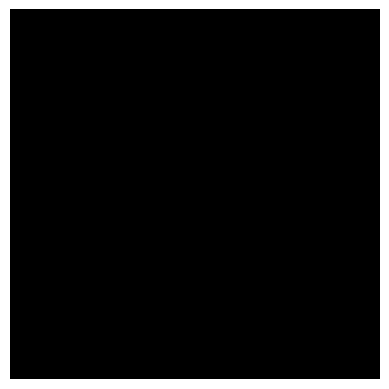

In [43]:
first_image = unaligned_1x[:, :, 0, 0]  # 获取第一张图像 (4096, 4096)

# 使用 matplotlib 展示第一张图像
plt.imshow(first_image, cmap='gray')  # 使用灰度色图展示
plt.axis('off')  # 关闭坐标轴
plt.show()

In [10]:
!pip install git+https://github.com/google-research/sofima

  Cloning https://github.com/google-research/sofima to /tmp/pip-req-build-r7_5hnrn
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/sofima /tmp/pip-req-build-r7_5hnrn
  Resolved https://github.com/google-research/sofima to commit 52a730b70fc49661bdb21d011b70bceb601d468b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.1/271.1 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00
  Created wheel for sofima: filename=sofima-20240120.dev45+g52a730b70-py3-none-any.whl size=93329 sha256=7ed8391e619a4252ec5075ec58efd7aabec4229b9e3cb64d025aafd4783533f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-b0oeekpz/wheels/27/2b/6a/ec514a660f0e3d29b8022931741c441aaeefc9dd98779ba549
Successfully built so

In [11]:
from concurrent import futures
import time

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from connectomics.common import bounding_box
from sofima import flow_field
from sofima import flow_utils
from sofima import map_utils
from sofima import mesh
from sofima import warp
from tqdm.notebook import tqdm

In [12]:
# Ensure that we're running this code on a GPU machine. If this fails and you're using
# Google Colab, use "Edit >> Notebook settings" and set s"Hardware accelerator" to "GPU".
assert jax.devices()[0].platform == 'gpu'

# Flow field estimation

First, we calculate the flow fields between the current section and the directly preceding section. Flow fields can also be computed between pairs of sections that are not directly adjacent. This is useful if sections are incomplete or missing, but is not something we have to worry about in this demo.

In a distributed environment, this step would be done with the `EstimateFlow` processor.


On a V100, the expected time for the flow calculation over a single 5000x5000 section with the settings below, is ~0.6s. The patch (160) and step (40) sizes are set to conservative values which work for most synaptic-resolution EM volumes (i.e. at an in-plane resolution of ~10 nm/px).


In [13]:
# Both of the settings below are expressed in pixels.
patch_size = 160  # XY spatial context used for flow field estimation
stride = 40  # XY distance between centers of adjacent patches.

def _compute_flow(volume):
  mfc = flow_field.JAXMaskedXCorrWithStatsCalculator()
  flows = []
  prev = volume[..., 0, 0].T.read().result()

  fs = []
  with futures.ThreadPoolExecutor() as tpe:
    # Prefetch the next sections to memory so that we don't have to wait for them
    # to load when the GPU becomes available.
    for z in range(1, unaligned_1x.shape[2]):
      fs.append(tpe.submit(lambda z=z: volume[..., z, 0].T.read().result()))

    fs = fs[::-1]

    for z in tqdm(range(1, unaligned_1x.shape[2])):
      curr = fs.pop().result()

      # The batch size is a parameter which impacts the efficiency of the computation (but
      # not its result). It has to be large enough for the computation to fully utilize the
      # available GPU capacity, but small enough so that the batch fits in GPU RAM.
      flows.append(mfc.flow_field(prev, curr, (patch_size, patch_size),
                                  (stride, stride), batch_size=256))
      prev = curr

  return flows

Compute flows at native and 2x reduced in-plane resolution. The lower resolution flow has reduced precision, but is helpful for providing approximate flow vectors in places where the full-resolution flow might be impossible to estimate, e.g. in the interior of cell bodies or blood vessels.


In [14]:
flows1x = np.array(_compute_flow(unaligned_1x))
flows2x = np.array(_compute_flow(unaligned_2x))

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

The flow fields generated in the previous step are 4-channel arrays, where the first two channels store the XY components of the flow vector, and the two remaining channels are measures of estimation quality (see `sofima.flow_field._batched_peaks` for more info).

In [15]:
# Convert to [channels, z, y, x].
flows2x = np.transpose(flows2x, [1, 0, 2, 3])
flows1x = np.transpose(flows1x, [1, 0, 2, 3])

# Pad to account for the edges of the images where there is insufficient context to estimate flow.
pad = patch_size // 2 // stride
flows1x = np.pad(flows1x, [[0, 0], [0, 0], [pad, pad], [pad, pad]], constant_values=np.nan)
flows2x = np.pad(flows2x, [[0, 0], [0, 0], [pad, pad], [pad, pad]], constant_values=np.nan)

We now remove uncertain flow estimates by replacing them with NaNs, and merge the two flow arrays into a single flow field at full resolution. In a distributed environment, this step would be done with the `ReconcileAndFilterFlows` processor.

In [16]:
f1 = flow_utils.clean_flow(flows1x, min_peak_ratio=1.6, min_peak_sharpness=1.6, max_magnitude=80, max_deviation=20)
f2 = flow_utils.clean_flow(flows2x, min_peak_ratio=1.6, min_peak_sharpness=1.6, max_magnitude=80, max_deviation=20)

Plot the horizontal component of the flow vector, before (left) and after (right) filtering. While blobs indicate areas where uncertain flow estimates were removed.

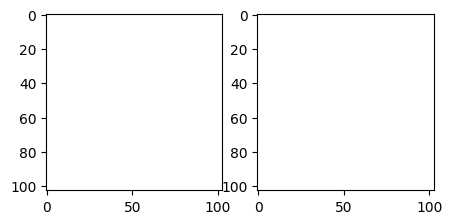

In [17]:
f, ax = plt.subplots(1, 2, figsize=(5, 2.5))
ax[0].imshow(flows1x[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)
ax[1].imshow(f1[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)

In [18]:
from scipy import interpolate
f2_hires = np.zeros_like(f1)

scale = 0.5
oy, ox = np.ogrid[:f2.shape[-2], :f2.shape[-1]]
oy = oy.ravel() / scale
ox = ox.ravel() / scale

box1x = bounding_box.BoundingBox(start=(0, 0, 0), size=(f1.shape[-1], f1.shape[-2], 1))
box2x = bounding_box.BoundingBox(start=(0, 0, 0), size=(f2.shape[-1], f2.shape[-2], 1))

for z in tqdm(range(f2.shape[1])):
  # Upsample and scale spatial components.
  resampled = map_utils.resample_map(
      f2[:, z:z + 1, ...],  #
      box2x, box1x, 1 / scale, 1)
  f2_hires[:, z:z + 1, ...] = resampled / scale

  0%|          | 0/199 [00:00<?, ?it/s]

In [19]:
final_flow = flow_utils.reconcile_flows((f1, f2_hires), max_gradient=0, max_deviation=20, min_patch_size=400)

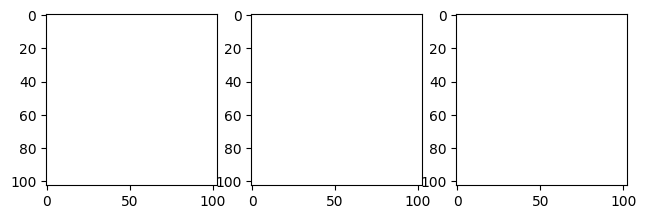

In [20]:
# Plot (left to right): high res. flow, upsampled low res. flow, combined flow to use for alignment.
f, ax = plt.subplots(1, 3, figsize=(7.5, 2.5))
ax[0].imshow(f1[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)
ax[1].imshow(f2_hires[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)
ax[2].imshow(final_flow[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)

# Mesh optimization

We use an elastic mesh optimizer to find a configuration of the imagery that is compatible with the estimated flow field and preserves the original geometry as much as possible.

The optimization proceeds sequentially, section by section. In a distributed environment, this computation can be parallelized across the plane (by independently solving overlapping XY tiles), as well as split into blocks along the Z axis. This makes it possible to scale this process to arbitrarily large volumes. For simplicity, here we solve the complete stack in one go.

In [21]:
config = mesh.IntegrationConfig(dt=0.001, gamma=0.0, k0=0.01, k=0.1, stride=(stride, stride), num_iters=1000,
                                max_iters=100000, stop_v_max=0.005, dt_max=1000, start_cap=0.01,
                                final_cap=10, prefer_orig_order=True)

In [22]:
solved = [np.zeros_like(final_flow[:, 0:1, ...])]
origin = jnp.array([0., 0.])

for z in tqdm(range(0, final_flow.shape[1])):
  prev = map_utils.compose_maps_fast(final_flow[:, z:z+1, ...], origin, stride,
                                     solved[-1], origin, stride)
  x = np.zeros_like(solved[0])
  x, e_kin, num_steps = mesh.relax_mesh(x, prev, config)
  x = np.array(x)
  solved.append(x)

  0%|          | 0/199 [00:00<?, ?it/s]

In [23]:
solved = np.concatenate(solved, axis=1)

# Image warping

Image warping requires an inverse coordinate map, so compute that first. In a distributed environment, this can be done with the `InvertMap` processor.

In [24]:
inv_map = map_utils.invert_map(solved, box1x, box1x, stride)

We are now ready to render the aligned subvolume. To reduce RAM usage, we render a 1000x1000 part for all 200 sections.

In a distributed environment, this can be done with the `WarpByMap` processor.

In [25]:
warped = [np.transpose(unaligned_1x[1000:2000, 2000:3000, 0:1, 0].read().result(), [2, 1, 0])]

for z in tqdm(range(1, unaligned_1x.shape[2])):
  data_box = bounding_box.BoundingBox(start=(500, 1500, 0), size=(2000, 2000, 1))
  out_box = bounding_box.BoundingBox(start=(1000, 2000, 0), size=(1000, 1000, 1))

  data = np.transpose(unaligned_1x[data_box.start[0]:data_box.end[0],
                                   data_box.start[1]:data_box.end[1],
                                   z:z+1, 0:1].read().result(), [3, 2, 1, 0])
  warped.append(
      warp.warp_subvolume(data, data_box, inv_map[:, z:z+1, ...], box1x, stride, out_box, 'lanczos', parallelism=1)[0, ...])

  0%|          | 0/199 [00:00<?, ?it/s]

In [42]:
import numpy as np
from PIL import Image
from tqdm import tqdm
import os

# 假设 warped 是一个包含图像数据的列表
# 这里的数据已经在 warped 中作为 numpy 数组保存了。

# 设置保存图片的目录
output_dir = "/content/drive/MyDrive/warped_images"  # 请替换为你希望保存图片的目录
os.makedirs(output_dir, exist_ok=True)

# 遍历 warped 中的每张图片并保存
for i, img_data in tqdm(enumerate(warped), desc="Saving images"):
    # img_data 是每一张图像的 numpy 数组，假设它是 2D 图像 (height, width)
    # 如果 img_data 是多维数组（例如，包含多个通道），我们只提取第一个通道
    img_data_single_channel = img_data.squeeze()  # 使其变为 2D 图像
    # 将 numpy 数组转换为 PIL 图像
    img = Image.fromarray(img_data_single_channel.astype(np.uint8))  # 转换为无符号 8 位整数图像
    # 保存图像
    output_image_path = os.path.join(output_dir, f"warped_image_{i+1:04d}.png")
    img.save(output_image_path)



Saving images: 6it [00:00, 52.52it/s]

(1, 1000, 1000)
(1000, 1000)
Image 1 saved at /content/drive/MyDrive/warped_images/warped_image_0001.png
(1, 1000, 1000)
(1000, 1000)
Image 2 saved at /content/drive/MyDrive/warped_images/warped_image_0002.png
(1, 1000, 1000)
(1000, 1000)
Image 3 saved at /content/drive/MyDrive/warped_images/warped_image_0003.png
(1, 1000, 1000)
(1000, 1000)
Image 4 saved at /content/drive/MyDrive/warped_images/warped_image_0004.png
(1, 1000, 1000)
(1000, 1000)
Image 5 saved at /content/drive/MyDrive/warped_images/warped_image_0005.png
(1, 1000, 1000)
(1000, 1000)
Image 6 saved at /content/drive/MyDrive/warped_images/warped_image_0006.png
(1, 1000, 1000)
(1000, 1000)
Image 7 saved at /content/drive/MyDrive/warped_images/warped_image_0007.png
(1, 1000, 1000)
(1000, 1000)
Image 8 saved at /content/drive/MyDrive/warped_images/warped_image_0008.png
(1, 1000, 1000)
(1000, 1000)
Image 9 saved at /content/drive/MyDrive/warped_images/warped_image_0009.png
(1, 1000, 1000)
(1000, 1000)
Image 10 saved at /content

Saving images: 20it [00:00, 59.32it/s]

Image 13 saved at /content/drive/MyDrive/warped_images/warped_image_0013.png
(1, 1000, 1000)
(1000, 1000)
Image 14 saved at /content/drive/MyDrive/warped_images/warped_image_0014.png
(1, 1000, 1000)
(1000, 1000)
Image 15 saved at /content/drive/MyDrive/warped_images/warped_image_0015.png
(1, 1000, 1000)
(1000, 1000)
Image 16 saved at /content/drive/MyDrive/warped_images/warped_image_0016.png
(1, 1000, 1000)
(1000, 1000)
Image 17 saved at /content/drive/MyDrive/warped_images/warped_image_0017.png
(1, 1000, 1000)
(1000, 1000)
Image 18 saved at /content/drive/MyDrive/warped_images/warped_image_0018.png
(1, 1000, 1000)
(1000, 1000)
Image 19 saved at /content/drive/MyDrive/warped_images/warped_image_0019.png
(1, 1000, 1000)
(1000, 1000)
Image 20 saved at /content/drive/MyDrive/warped_images/warped_image_0020.png
(1, 1000, 1000)
(1000, 1000)
Image 21 saved at /content/drive/MyDrive/warped_images/warped_image_0021.png
(1, 1000, 1000)
(1000, 1000)
Image 22 saved at /content/drive/MyDrive/warpe

Saving images: 34it [00:00, 59.71it/s]

Image 26 saved at /content/drive/MyDrive/warped_images/warped_image_0026.png
(1, 1000, 1000)
(1000, 1000)
Image 27 saved at /content/drive/MyDrive/warped_images/warped_image_0027.png
(1, 1000, 1000)
(1000, 1000)
Image 28 saved at /content/drive/MyDrive/warped_images/warped_image_0028.png
(1, 1000, 1000)
(1000, 1000)
Image 29 saved at /content/drive/MyDrive/warped_images/warped_image_0029.png
(1, 1000, 1000)
(1000, 1000)
Image 30 saved at /content/drive/MyDrive/warped_images/warped_image_0030.png
(1, 1000, 1000)
(1000, 1000)
Image 31 saved at /content/drive/MyDrive/warped_images/warped_image_0031.png
(1, 1000, 1000)
(1000, 1000)
Image 32 saved at /content/drive/MyDrive/warped_images/warped_image_0032.png
(1, 1000, 1000)
(1000, 1000)
Image 33 saved at /content/drive/MyDrive/warped_images/warped_image_0033.png
(1, 1000, 1000)
(1000, 1000)
Image 34 saved at /content/drive/MyDrive/warped_images/warped_image_0034.png
(1, 1000, 1000)
(1000, 1000)
Image 35 saved at /content/drive/MyDrive/warpe

Saving images: 47it [00:00, 61.12it/s]

Image 38 saved at /content/drive/MyDrive/warped_images/warped_image_0038.png
(1, 1000, 1000)
(1000, 1000)
Image 39 saved at /content/drive/MyDrive/warped_images/warped_image_0039.png
(1, 1000, 1000)
(1000, 1000)
Image 40 saved at /content/drive/MyDrive/warped_images/warped_image_0040.png
(1, 1000, 1000)
(1000, 1000)
Image 41 saved at /content/drive/MyDrive/warped_images/warped_image_0041.png
(1, 1000, 1000)
(1000, 1000)
Image 42 saved at /content/drive/MyDrive/warped_images/warped_image_0042.png
(1, 1000, 1000)
(1000, 1000)
Image 43 saved at /content/drive/MyDrive/warped_images/warped_image_0043.png
(1, 1000, 1000)
(1000, 1000)
Image 44 saved at /content/drive/MyDrive/warped_images/warped_image_0044.png
(1, 1000, 1000)
(1000, 1000)
Image 45 saved at /content/drive/MyDrive/warped_images/warped_image_0045.png
(1, 1000, 1000)
(1000, 1000)
Image 46 saved at /content/drive/MyDrive/warped_images/warped_image_0046.png
(1, 1000, 1000)
(1000, 1000)
Image 47 saved at /content/drive/MyDrive/warpe

Saving images: 61it [00:01, 59.77it/s]

Image 51 saved at /content/drive/MyDrive/warped_images/warped_image_0051.png
(1, 1000, 1000)
(1000, 1000)
Image 52 saved at /content/drive/MyDrive/warped_images/warped_image_0052.png
(1, 1000, 1000)
(1000, 1000)
Image 53 saved at /content/drive/MyDrive/warped_images/warped_image_0053.png
(1, 1000, 1000)
(1000, 1000)
Image 54 saved at /content/drive/MyDrive/warped_images/warped_image_0054.png
(1, 1000, 1000)
(1000, 1000)
Image 55 saved at /content/drive/MyDrive/warped_images/warped_image_0055.png
(1, 1000, 1000)
(1000, 1000)
Image 56 saved at /content/drive/MyDrive/warped_images/warped_image_0056.png
(1, 1000, 1000)
(1000, 1000)
Image 57 saved at /content/drive/MyDrive/warped_images/warped_image_0057.png
(1, 1000, 1000)
(1000, 1000)
Image 58 saved at /content/drive/MyDrive/warped_images/warped_image_0058.png
(1, 1000, 1000)
(1000, 1000)
Image 59 saved at /content/drive/MyDrive/warped_images/warped_image_0059.png
(1, 1000, 1000)
(1000, 1000)
Image 60 saved at /content/drive/MyDrive/warpe

Saving images: 74it [00:01, 56.58it/s]

Image 64 saved at /content/drive/MyDrive/warped_images/warped_image_0064.png
(1, 1000, 1000)
(1000, 1000)
Image 65 saved at /content/drive/MyDrive/warped_images/warped_image_0065.png
(1, 1000, 1000)
(1000, 1000)
Image 66 saved at /content/drive/MyDrive/warped_images/warped_image_0066.png
(1, 1000, 1000)
(1000, 1000)
Image 67 saved at /content/drive/MyDrive/warped_images/warped_image_0067.png
(1, 1000, 1000)
(1000, 1000)
Image 68 saved at /content/drive/MyDrive/warped_images/warped_image_0068.png
(1, 1000, 1000)
(1000, 1000)
Image 69 saved at /content/drive/MyDrive/warped_images/warped_image_0069.png
(1, 1000, 1000)
(1000, 1000)
Image 70 saved at /content/drive/MyDrive/warped_images/warped_image_0070.png
(1, 1000, 1000)
(1000, 1000)
Image 71 saved at /content/drive/MyDrive/warped_images/warped_image_0071.png
(1, 1000, 1000)
(1000, 1000)
Image 72 saved at /content/drive/MyDrive/warped_images/warped_image_0072.png
(1, 1000, 1000)
(1000, 1000)
Image 73 saved at /content/drive/MyDrive/warpe

Saving images: 81it [00:01, 58.34it/s]

Image 75 saved at /content/drive/MyDrive/warped_images/warped_image_0075.png
(1, 1000, 1000)
(1000, 1000)
Image 76 saved at /content/drive/MyDrive/warped_images/warped_image_0076.png
(1, 1000, 1000)
(1000, 1000)
Image 77 saved at /content/drive/MyDrive/warped_images/warped_image_0077.png
(1, 1000, 1000)
(1000, 1000)
Image 78 saved at /content/drive/MyDrive/warped_images/warped_image_0078.png
(1, 1000, 1000)
(1000, 1000)
Image 79 saved at /content/drive/MyDrive/warped_images/warped_image_0079.png
(1, 1000, 1000)
(1000, 1000)
Image 80 saved at /content/drive/MyDrive/warped_images/warped_image_0080.png
(1, 1000, 1000)
(1000, 1000)
Image 81 saved at /content/drive/MyDrive/warped_images/warped_image_0081.png
(1, 1000, 1000)
(1000, 1000)
Image 82 saved at /content/drive/MyDrive/warped_images/warped_image_0082.png
(1, 1000, 1000)
(1000, 1000)
Image 83 saved at /content/drive/MyDrive/warped_images/warped_image_0083.png
(1, 1000, 1000)
(1000, 1000)
Image 84 saved at /content/drive/MyDrive/warpe

Saving images: 94it [00:01, 56.81it/s]

Image 86 saved at /content/drive/MyDrive/warped_images/warped_image_0086.png
(1, 1000, 1000)
(1000, 1000)
Image 87 saved at /content/drive/MyDrive/warped_images/warped_image_0087.png
(1, 1000, 1000)
(1000, 1000)
Image 88 saved at /content/drive/MyDrive/warped_images/warped_image_0088.png
(1, 1000, 1000)
(1000, 1000)
Image 89 saved at /content/drive/MyDrive/warped_images/warped_image_0089.png
(1, 1000, 1000)
(1000, 1000)
Image 90 saved at /content/drive/MyDrive/warped_images/warped_image_0090.png
(1, 1000, 1000)
(1000, 1000)
Image 91 saved at /content/drive/MyDrive/warped_images/warped_image_0091.png
(1, 1000, 1000)
(1000, 1000)
Image 92 saved at /content/drive/MyDrive/warped_images/warped_image_0092.png
(1, 1000, 1000)
(1000, 1000)
Image 93 saved at /content/drive/MyDrive/warped_images/warped_image_0093.png
(1, 1000, 1000)
(1000, 1000)
Image 94 saved at /content/drive/MyDrive/warped_images/warped_image_0094.png
(1, 1000, 1000)
(1000, 1000)
Image 95 saved at /content/drive/MyDrive/warpe

Saving images: 107it [00:01, 57.47it/s]

Image 98 saved at /content/drive/MyDrive/warped_images/warped_image_0098.png
(1, 1000, 1000)
(1000, 1000)
Image 99 saved at /content/drive/MyDrive/warped_images/warped_image_0099.png
(1, 1000, 1000)
(1000, 1000)
Image 100 saved at /content/drive/MyDrive/warped_images/warped_image_0100.png
(1, 1000, 1000)
(1000, 1000)
Image 101 saved at /content/drive/MyDrive/warped_images/warped_image_0101.png
(1, 1000, 1000)
(1000, 1000)
Image 102 saved at /content/drive/MyDrive/warped_images/warped_image_0102.png
(1, 1000, 1000)
(1000, 1000)
Image 103 saved at /content/drive/MyDrive/warped_images/warped_image_0103.png
(1, 1000, 1000)
(1000, 1000)
Image 104 saved at /content/drive/MyDrive/warped_images/warped_image_0104.png
(1, 1000, 1000)
(1000, 1000)
Image 105 saved at /content/drive/MyDrive/warped_images/warped_image_0105.png
(1, 1000, 1000)
(1000, 1000)
Image 106 saved at /content/drive/MyDrive/warped_images/warped_image_0106.png
(1, 1000, 1000)
(1000, 1000)
Image 107 saved at /content/drive/MyDri

Saving images: 120it [00:02, 57.39it/s]

Image 111 saved at /content/drive/MyDrive/warped_images/warped_image_0111.png
(1, 1000, 1000)
(1000, 1000)
Image 112 saved at /content/drive/MyDrive/warped_images/warped_image_0112.png
(1, 1000, 1000)
(1000, 1000)
Image 113 saved at /content/drive/MyDrive/warped_images/warped_image_0113.png
(1, 1000, 1000)
(1000, 1000)
Image 114 saved at /content/drive/MyDrive/warped_images/warped_image_0114.png
(1, 1000, 1000)
(1000, 1000)
Image 115 saved at /content/drive/MyDrive/warped_images/warped_image_0115.png
(1, 1000, 1000)
(1000, 1000)
Image 116 saved at /content/drive/MyDrive/warped_images/warped_image_0116.png
(1, 1000, 1000)
(1000, 1000)
Image 117 saved at /content/drive/MyDrive/warped_images/warped_image_0117.png
(1, 1000, 1000)
(1000, 1000)
Image 118 saved at /content/drive/MyDrive/warped_images/warped_image_0118.png
(1, 1000, 1000)
(1000, 1000)
Image 119 saved at /content/drive/MyDrive/warped_images/warped_image_0119.png
(1, 1000, 1000)
(1000, 1000)
Image 120 saved at /content/drive/MyD

Saving images: 133it [00:02, 58.37it/s]

Image 123 saved at /content/drive/MyDrive/warped_images/warped_image_0123.png
(1, 1000, 1000)
(1000, 1000)
Image 124 saved at /content/drive/MyDrive/warped_images/warped_image_0124.png
(1, 1000, 1000)
(1000, 1000)
Image 125 saved at /content/drive/MyDrive/warped_images/warped_image_0125.png
(1, 1000, 1000)
(1000, 1000)
Image 126 saved at /content/drive/MyDrive/warped_images/warped_image_0126.png
(1, 1000, 1000)
(1000, 1000)
Image 127 saved at /content/drive/MyDrive/warped_images/warped_image_0127.png
(1, 1000, 1000)
(1000, 1000)
Image 128 saved at /content/drive/MyDrive/warped_images/warped_image_0128.png
(1, 1000, 1000)
(1000, 1000)
Image 129 saved at /content/drive/MyDrive/warped_images/warped_image_0129.png
(1, 1000, 1000)
(1000, 1000)
Image 130 saved at /content/drive/MyDrive/warped_images/warped_image_0130.png
(1, 1000, 1000)
(1000, 1000)
Image 131 saved at /content/drive/MyDrive/warped_images/warped_image_0131.png
(1, 1000, 1000)
(1000, 1000)
Image 132 saved at /content/drive/MyD

Saving images: 140it [00:02, 59.69it/s]

Image 135 saved at /content/drive/MyDrive/warped_images/warped_image_0135.png
(1, 1000, 1000)
(1000, 1000)
Image 136 saved at /content/drive/MyDrive/warped_images/warped_image_0136.png
(1, 1000, 1000)
(1000, 1000)
Image 137 saved at /content/drive/MyDrive/warped_images/warped_image_0137.png
(1, 1000, 1000)
(1000, 1000)
Image 138 saved at /content/drive/MyDrive/warped_images/warped_image_0138.png
(1, 1000, 1000)
(1000, 1000)
Image 139 saved at /content/drive/MyDrive/warped_images/warped_image_0139.png
(1, 1000, 1000)
(1000, 1000)
Image 140 saved at /content/drive/MyDrive/warped_images/warped_image_0140.png
(1, 1000, 1000)
(1000, 1000)
Image 141 saved at /content/drive/MyDrive/warped_images/warped_image_0141.png
(1, 1000, 1000)
(1000, 1000)
Image 142 saved at /content/drive/MyDrive/warped_images/warped_image_0142.png
(1, 1000, 1000)
(1000, 1000)
Image 143 saved at /content/drive/MyDrive/warped_images/warped_image_0143.png
(1, 1000, 1000)
(1000, 1000)
Image 144 saved at /content/drive/MyD

Saving images: 152it [00:02, 56.93it/s]

(1, 1000, 1000)
(1000, 1000)
Image 147 saved at /content/drive/MyDrive/warped_images/warped_image_0147.png
(1, 1000, 1000)
(1000, 1000)
Image 148 saved at /content/drive/MyDrive/warped_images/warped_image_0148.png
(1, 1000, 1000)
(1000, 1000)
Image 149 saved at /content/drive/MyDrive/warped_images/warped_image_0149.png
(1, 1000, 1000)
(1000, 1000)
Image 150 saved at /content/drive/MyDrive/warped_images/warped_image_0150.png
(1, 1000, 1000)
(1000, 1000)
Image 151 saved at /content/drive/MyDrive/warped_images/warped_image_0151.png
(1, 1000, 1000)
(1000, 1000)
Image 152 saved at /content/drive/MyDrive/warped_images/warped_image_0152.png
(1, 1000, 1000)
(1000, 1000)
Image 153 saved at /content/drive/MyDrive/warped_images/warped_image_0153.png
(1, 1000, 1000)
(1000, 1000)
Image 154 saved at /content/drive/MyDrive/warped_images/warped_image_0154.png
(1, 1000, 1000)
(1000, 1000)
Image 155 saved at /content/drive/MyDrive/warped_images/warped_image_0155.png
(1, 1000, 1000)
(1000, 1000)
Image 15

Saving images: 164it [00:02, 51.43it/s]

Image 158 saved at /content/drive/MyDrive/warped_images/warped_image_0158.png
(1, 1000, 1000)
(1000, 1000)
Image 159 saved at /content/drive/MyDrive/warped_images/warped_image_0159.png
(1, 1000, 1000)
(1000, 1000)
Image 160 saved at /content/drive/MyDrive/warped_images/warped_image_0160.png
(1, 1000, 1000)
(1000, 1000)
Image 161 saved at /content/drive/MyDrive/warped_images/warped_image_0161.png
(1, 1000, 1000)
(1000, 1000)
Image 162 saved at /content/drive/MyDrive/warped_images/warped_image_0162.png
(1, 1000, 1000)
(1000, 1000)
Image 163 saved at /content/drive/MyDrive/warped_images/warped_image_0163.png
(1, 1000, 1000)
(1000, 1000)
Image 164 saved at /content/drive/MyDrive/warped_images/warped_image_0164.png
(1, 1000, 1000)
(1000, 1000)
Image 165 saved at /content/drive/MyDrive/warped_images/warped_image_0165.png
(1, 1000, 1000)
(1000, 1000)
Image 166 saved at /content/drive/MyDrive/warped_images/warped_image_0166.png
(1, 1000, 1000)
(1000, 1000)
Image 167 saved at /content/drive/MyD

Saving images: 177it [00:03, 54.14it/s]

Image 168 saved at /content/drive/MyDrive/warped_images/warped_image_0168.png
(1, 1000, 1000)
(1000, 1000)
Image 169 saved at /content/drive/MyDrive/warped_images/warped_image_0169.png
(1, 1000, 1000)
(1000, 1000)
Image 170 saved at /content/drive/MyDrive/warped_images/warped_image_0170.png
(1, 1000, 1000)
(1000, 1000)
Image 171 saved at /content/drive/MyDrive/warped_images/warped_image_0171.png
(1, 1000, 1000)
(1000, 1000)
Image 172 saved at /content/drive/MyDrive/warped_images/warped_image_0172.png
(1, 1000, 1000)
(1000, 1000)
Image 173 saved at /content/drive/MyDrive/warped_images/warped_image_0173.png
(1, 1000, 1000)
(1000, 1000)
Image 174 saved at /content/drive/MyDrive/warped_images/warped_image_0174.png
(1, 1000, 1000)
(1000, 1000)
Image 175 saved at /content/drive/MyDrive/warped_images/warped_image_0175.png
(1, 1000, 1000)
(1000, 1000)
Image 176 saved at /content/drive/MyDrive/warped_images/warped_image_0176.png
(1, 1000, 1000)
(1000, 1000)
Image 177 saved at /content/drive/MyD

Saving images: 194it [00:03, 66.10it/s]

Image 181 saved at /content/drive/MyDrive/warped_images/warped_image_0181.png
(1, 1000, 1000)
(1000, 1000)
Image 182 saved at /content/drive/MyDrive/warped_images/warped_image_0182.png
(1, 1000, 1000)
(1000, 1000)
Image 183 saved at /content/drive/MyDrive/warped_images/warped_image_0183.png
(1, 1000, 1000)
(1000, 1000)
Image 184 saved at /content/drive/MyDrive/warped_images/warped_image_0184.png
(1, 1000, 1000)
(1000, 1000)
Image 185 saved at /content/drive/MyDrive/warped_images/warped_image_0185.png
(1, 1000, 1000)
(1000, 1000)
Image 186 saved at /content/drive/MyDrive/warped_images/warped_image_0186.png
(1, 1000, 1000)
(1000, 1000)
Image 187 saved at /content/drive/MyDrive/warped_images/warped_image_0187.png
(1, 1000, 1000)
(1000, 1000)
Image 188 saved at /content/drive/MyDrive/warped_images/warped_image_0188.png
(1, 1000, 1000)
(1000, 1000)
Image 189 saved at /content/drive/MyDrive/warped_images/warped_image_0189.png
(1, 1000, 1000)
(1000, 1000)
Image 190 saved at /content/drive/MyD

Saving images: 200it [00:03, 59.02it/s]

Image 198 saved at /content/drive/MyDrive/warped_images/warped_image_0198.png
(1, 1000, 1000)
(1000, 1000)
Image 199 saved at /content/drive/MyDrive/warped_images/warped_image_0199.png
(1, 1000, 1000)
(1000, 1000)
Image 200 saved at /content/drive/MyDrive/warped_images/warped_image_0200.png


In [26]:
warped_xyz = np.transpose(np.concatenate(warped, axis=0), [2, 1, 0])

Render an XZ cross section to check the quality of the alignment visually.

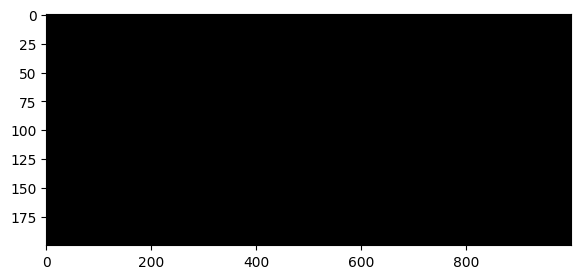

In [27]:
plt.figure(figsize=(7, 3))
plt.imshow(warped_xyz[:, 500, :].T, cmap=plt.cm.Greys_r, aspect=(1000 * 11) / (200 * 25))

The results can be inspected interactively in Neuroglancer as well.

In [28]:
!pip install neuroglancer
import neuroglancer

dimensions = neuroglancer.CoordinateSpace(names=['x', 'y', 'z'], units='nm', scales=[11, 11, 25])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
  s.dimensions = dimensions
  s.layers['em'] = neuroglancer.ImageLayer(source=neuroglancer.LocalVolume(warped_xyz, dimensions))

viewer

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.2/135.2 kB 14.3 MB/s eta 0:00:00
  Created wheel for atomicwrites: filename=atomicwrites-1.4.1-py2.py3-none-any.whl size=6943 sha256=403d6e0ce855f7a3467ea7c4fee719917064a9eb054928aba86db214610cdff7
  Stored in directory: /root/.cache/pip/wheels/6b/37/a4/ae30755673c2d1e07228f13b4491fcaef62438f771d5012d07
Successfully built atomicwrites


https://34301-gpu-t4-s-1yt9od5ardh9v-c.asia-southeast1-2.prod.colab.dev/v/4e42950cd2444dda48c4fc86cd9e50a56cd3c329/

# Distributed mesh optimization

The serial mesh optimization process described above might be too slow for large volumes. Fortunately, mesh optimization can be parallelized by splitting the volume into overlapping blocks of sections, solving the blocks independently in parallel, and reconciling the solutions to produce a globally consistent mesh.

If we now represent every block as a virtual "section" and use solved state of the last section of every block as the "flow field", we can reuse the existing SOFIMA functionality to optimize a new mesh representing the blocks. This can then be combined with the in-block meshes to form a global solution.

To demonstrate how this works, we will now solve the same mesh as before independently for [0..50], [50..100], [100..150], [150..199]. Note that the blocks overlap by exactly one and that in a real setting, this would be done in parallel instead of in a loop.


In [29]:
from connectomics.volume import subvolume
from sofima.processor import maps

In [30]:
block1 = [np.zeros_like(final_flow[:, 0:1, ...])]
block2 = [np.zeros_like(final_flow[:, 0:1, ...])]
block3 = [np.zeros_like(final_flow[:, 0:1, ...])]
block4 = [np.zeros_like(final_flow[:, 0:1, ...])]

for blk, start, stop in ((block1, 0, 50), (block2, 50, 100), (block3, 100, 150), (block4, 150, final_flow.shape[1])):
  for z in tqdm(range(start, stop)):
    prev = map_utils.compose_maps_fast(final_flow[:, z:z+1, ...], origin, stride,
                                       blk[-1], origin, stride)
    x = np.zeros_like(blk[0])
    x, e_kin, num_steps = mesh.relax_mesh(x, prev, config)
    x = np.array(x)
    blk.append(x)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [31]:
block1 = np.concatenate(block1, axis=1)
block2 = np.concatenate(block2, axis=1)
block3 = np.concatenate(block3, axis=1)
block4 = np.concatenate(block4, axis=1)

The mesh for the last section of 'block1' tells us where the first section of 'block2' should be, if block2 was aligned to block1. This mesh data for the last section of every block can be stacked to form a 'cross-block' flow field. We will downsample it 2x in-plane as the block-wise mesh can be coarser.


In [32]:
map_box = bounding_box.BoundingBox(start=(0, 0, 0), size=block1.shape[1:][::-1])
map2x_box = map_box.scale(0.5)
xblk_stride = stride * 2

In [33]:
xblock_flow = np.stack([block1[:, -1, ...], block2[:, -1, ...],
                        block3[:, -1, ...], block4[:, -1, ...]], axis=1)
xblock_flow = map_utils.resample_map(xblock_flow, map_box, map2x_box, stride, xblk_stride)

With the flow field prepared, we are aready to optimize the block-wise mesh. To take into account that every mesh section represents a much thicker piece of physical tissue, we lower the value of $k_0$, making the inter-section forces weak relative to the intra-section ones.

In [34]:
xblk_config = mesh.IntegrationConfig(dt=0.001, gamma=0.0, k0=0.001, k=0.1, stride=(xblk_stride, xblk_stride), num_iters=1000,
                                     max_iters=100000, stop_v_max=0.005, dt_max=1000, start_cap=0.01,
                                     final_cap=10, prefer_orig_order=True)

xblk = []
for z in tqdm(range(xblock_flow.shape[1])):
  if z == 0:
    prev = xblock_flow[:, z:z+1, ...]
  else:
    prev = map_utils.compose_maps_fast(xblock_flow[:, z:z+1, ...], origin, xblk_stride, xblk[-1], origin, xblk_stride)
  x = np.zeros_like(xblock_flow[:, 0:1, ...])
  x, e_kin, num_steps = mesh.relax_mesh(x, prev, xblk_config)
  x = np.array(x)
  xblk.append(x)

  0%|          | 0/4 [00:00<?, ?it/s]

In [35]:
xblk = np.concatenate(xblk, axis=1)

The cross-block mesh can now be combined with the per-block solutions to form a globally consistent mesh.

In [36]:
main = np.concatenate([block1[:, :50], block2[:, :50], block3[:, :50], block4], axis=1)
last = np.zeros_like(main)
last[:, 50, ...] = block1[:, -1, ...]
last[:, 100, ...] = block2[:, -1, ...]
last[:, 150, ...] = block3[:, -1, ...]
last[:, 199, ...] = block4[:, -1, ...]

main_inv = map_utils.invert_map(main, map_box, map_box, stride)
last_inv = map_utils.invert_map(last, map_box, map_box, stride)
xblk_upsampled = map_utils.resample_map(xblk, map2x_box, map_box, stride * 2, stride)
xblk_inv = map_utils.invert_map(xblk_upsampled, map_box, map_box, stride)

In [37]:
class ReconcileCrossBlockMaps(maps.ReconcileCrossBlockMaps):
  def _open_volume(self, path: str):
    if path == 'main_inv':
      return main_inv
    elif path == 'last_inv':
      return last_inv
    elif path == 'xblk':
      return xblk_upsampled
    elif path == 'xblk_inv':
      return xblk_inv
    else:
      raise ValueError(f'Unknown volume {path}')

config = maps.ReconcileCrossBlockMaps.Config(
    cross_block='xblk',
    cross_block_inv='xblk_inv',
    last_inv='last_inv',
    main_inv='main_inv',
    z_map={'50': 0, '100': 1, '150': 2, '199': 3},
    stride=stride,
    xy_overlap=0)
reconcile = ReconcileCrossBlockMaps(config)
reconcile.set_effective_subvol_and_overlap(map_box.size, (0, 0, 0))
main_box = bounding_box.BoundingBox(start=(0, 0, 0), size=main.shape[1:][::-1])
global_map = reconcile.process(subvolume.Subvolume(main, main_box))

We're now ready to render the aligned images...

In [38]:
global_map_inv = map_utils.invert_map(global_map.data, map_box, map_box, stride)
warped2 = [np.transpose(unaligned_1x[1000:2000, 2000:3000, 0:1, 0].read().result(), [2, 1, 0])]

for z in tqdm(range(1, unaligned_1x.shape[2])):
  data_box = bounding_box.BoundingBox(start=(500, 1500, 0), size=(2000, 2000, 1))
  out_box = bounding_box.BoundingBox(start=(1000, 2000, 0), size=(1000, 1000, 1))

  data = np.transpose(unaligned_1x[data_box.start[0]:data_box.end[0],
                                   data_box.start[1]:data_box.end[1],
                                   z:z+1, 0:1].read().result(), [3, 2, 1, 0])
  warped2.append(
      warp.warp_subvolume(data, data_box, global_map_inv[:, z:z+1, ...], box1x, stride, out_box, 'lanczos', parallelism=1)[0, ...])

warped2_xyz = np.transpose(np.concatenate(warped2, axis=0), [2, 1, 0])

  0%|          | 0/199 [00:00<?, ?it/s]

... and inspect them as a static image ...

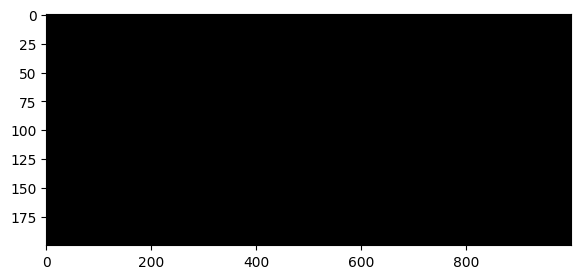

In [39]:
plt.figure(figsize=(7, 3))
plt.imshow(warped2_xyz[:, 500, :].T, cmap=plt.cm.Greys_r, aspect=(1000 * 11) / (200 * 25))

... or interactively.

In [40]:
import neuroglancer

dimensions = neuroglancer.CoordinateSpace(names=['x', 'y', 'z'], units='nm', scales=[11, 11, 25])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
  s.dimensions = dimensions
  s.layers['em'] = neuroglancer.ImageLayer(source=neuroglancer.LocalVolume(warped2_xyz, dimensions))

viewer

https://34301-gpu-t4-s-1yt9od5ardh9v-c.asia-southeast1-2.prod.colab.dev/v/165412080f6a6467dbbbd574a0eb945f9827f8e0/